## Consensus modelling for prediction of Blood-brain barrier penetration

Here we demonstrate how a consensus modelling could be used to make predictions about the blood-brain-barrier (BBB) penetration. We use the predictions from three independent models along with the information about their reliability (positive/negative predictive values) and combine these evidences according to the Dempster-Shafer theory (DST). The three independent models and their corresponding predictions are **Jaqpot**, **Lazar** and **Conformal predictions**.

Consensus predictions are stored in tabular format (*consensus_predictions.csv*) as well as plots (*predictions_vs_evidence.png* and *predictions_vs_true.png*). Intermediate results (combined evidence that is directly used for consensus predictions) are outputted into *evidences.csv*.

**NOTE:** in the input files the compounds are identified only through their SMILES. This script accesses the Pubchem and obtains the IUPAC names and synonyms for these compounds based on their SMILES strings. This is a time consuming step and therefore should be executed only once. Dictionaries that map from SMILES to IUPCA name/synonym are stored in two json files, *smilesToName.json* and *smilesToSyn.json*.

### Dempster-Shafer theory

DST provides a way to combine multiple sources of evidence to arrive at the consensus prediction. In our case, we would like to predict whether a given compound is BBB penetrating or not. For this purpose we combine predictions of three independent models along with the information about the reliability of their predictions, i.e. positive/negative predictive values (PPV, NPV). There is still some subjectivity in how we combine multiple sources of evidence, in particular how much weight we put on agreements/disagreements between the evidences. This is reflected in the choice of the combination rule:

- **Dempster rule (D):** puts more weight onto agreement between the various sources of evidence and tends to neglect disagreements.

- **Yager rule (Y):** tends to put more weight on conflicting evidences, resulting in less certain predictions in such cases.

To estimate how certain we are in the prediction of individual models, we have to evaluate their performance by e.g. cross-validation. Based on the cross-validation predictions, we can calculate positive and negative predictive values (PPV and NPV). PPV represents the fraction of true positive answers among all positive answers (`PPV = TP / (TP + FP`), and NPV represents the fraction of true negative answers among all negative answers (`NPV = TN / (TN + FN)`). Hence, PPV and NPV can be used to estimate how much can we trust to a positive or negative prediction of a certain model.

Predictions as well as PPV/NPV for each of the models were obtained from the k-fold cross-validation:

<table>
  <tr align="left"><b>
    <th></th>
    <th>Jaqpot</th>
    <th>LAZAR</th>
    <th>Conformal<br />prediction</th>
  </b></tr>
  <tr>
    <td><b>PPV</b></td>
    <td>0.738</td>
    <td>0.886</td>
    <td>0.809</td>
  </tr>
  <tr>
    <td><b>NPV</b></td>
    <td>0.687</td>
    <td>0.489</td>
    <td>0.701</td>
  </tr>
  <tr>
      <td><b>Predictions</b></td>
      <td><i>predictions_jaqpot.csv</i></td>
      <td><i>predictions_lazar.csv</i></td>  
      <td><i>predictions_cvap.csv</i></td>
  </tr>
</table>

DST provides a way to calculate the belief, uncertainty and plausability for every outcome, penetrating (P) and non-penetrating (NP). **Belief** and **plausability** can be viewed as the lower and upper bound on the probability of the associated outcome, while **uncertainty** represents the probability associated with both outcomes. With other words, belief for a certain outcome increases, when there is a stronger evidence directly supporting this outcome and not supporting other outcomes. Plausability for a certain outcome increases, when there is more evidence not contradicting the outcome. Plausability is just the sum of belief and uncertainty (`Plausability(P) = Belief(P) + Uncertainty` and `Plausability(N) = Belief(N) + Uncertainty`). The sum of beliefs and uncertainty should always sum to 1 (`Belief(P) + Uncertainty + Belief(N) = 1`).

**Consensus prediction** is the outcome associated with the belief that is larger than 0.5. If neither belief is greater than 0.5, then consensus prediction os equivocal.

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import dst  # custom module for Dempster-Shafer theory

**Set to true, if chemical names and synonyms have to be collected from Pubchem (otherwise *smilesToName.json* and *smilesToSyn.json* will be read)**

In [2]:
namesFromPubchem = False

**Import prediction of Jaqpot, Lazar and Conformal models and drop the first column, which is just index**

In [3]:
df1 = pd.read_csv('predictions_jaqpot.csv')
df1 = df1.drop(columns=df1.columns[0])
df1 = df1.rename(columns={'Predicted': 'Predicted_J'})

df2 = pd.read_csv('predictions_lazar.csv')
df2 = df2.drop(columns=df2.columns[0])


df3 = pd.read_csv('predictions_cvap.csv', sep="\t")
df3 = df3.iloc[:, 0:4]
df3.columns = ['SMILES', 'Blood-Brain-Barrier Penetration', 'P(N)', 'P(P)']

print('Shapes of source dataframes:', df1.shape, df2.shape, df3.shape)

Shapes of source dataframes: (388, 3) (415, 6) (415, 4)


**Additional curation of source dataframes**

In [4]:
# drop duplicated SMILES (later could be problems with merging)
df1 = df1.drop_duplicates(subset="SMILES")
df2 = df2.drop_duplicates(subset="SMILES")
df3 = df3.drop_duplicates(subset='SMILES')

# Set SMILES as index for merging the datasets
df1 = df1.set_index('SMILES')
df2 = df2.set_index('SMILES')
df3 = df3.set_index('SMILES')

# Convert predictions of Lazar model to numerics
df2['Predicted_L'] = df2['Prediction'].map({'penetrating': 1, 'non-penetrating': 0})

**Merge source datasets**

In [5]:
pred = pd.merge(df1, df2[['Predicted_L']], on='SMILES')
pred = pd.merge(pred, df3[['P(P)']].rename(columns={'P(P)': 'Predicted_C'}), on='SMILES')

**Drop NA (Lazar model has certain NA predictions)**

In [6]:
pred = pred.dropna()

**Print the filtered predictions of both models in the csv file**

In [7]:
pred.to_csv('evidences.csv')

pred.head()

,Blood-Brain-Barrier Penetration,Predicted_J,Predicted_L,Predicted_C
SMILES,,,,
OC[C@](c1onc(n1)c1ncn2-c3cccc(c3C(=O)N(Cc12)C)Cl)(O)C,0,1,1.0,0.313
NCCc1nc2n(c1)cccc2,0,1,1.0,0.551
CCCN(CCC)CCc1ccc(c2c1CC(=C)N2)O,1,1,1.0,0.944
Fc1ccc2c(c1)onc2C1CCN(CC1)CCc1c(C)nc2n(c1=O)CCC[C@H]2O,1,1,1.0,0.756
Clc1ccc2-n3c(CN=C(c2c1)c1ccccc1)nnc3C,1,1,1.0,0.958


**Loop over chemicals in the "pred" dataframe. For each chemical compute belief and uncertainty and make a consensus prediction.**

Note that `dst` module uses symbols S and N to designate positive and negative predictions, which are in our case penetrating and non-penetrating compunds. In the next step, these symbols are renamed to the specific case of BBB penetration (S = penetrating, N = non-penetrating)

In [8]:
# initiate a list of dictionaries, which will be converted to dataframe of results then
results = []

for index, row in pred.iterrows():
    
    # initiate a list of basic mass probabilities for all sources of evidence
    m = []
    
    # source 0 - compute basic mass probabilities
    if row['Predicted_J'] == 1:
        state = 'S'
    else:
        state = 'N'
    probability = 1.
    ppv, npv = 0.738, 0.687
    m0 = dst.assignBasicMassProb(state, probability, ppv, npv)
    m.append(m0)  # add to list

    # source 1 - compute basic mass probabilities
    if row['Predicted_L'] == 1:
        state = 'S'
    else:
        state = 'N'
    probability = 1.
    ppv, npv = 0.886, 0.489
    m1 = dst.assignBasicMassProb(state, probability, ppv, npv)
    m.append(m1)  # add to list
    
    # source 2
    ppv, npv = 0.809, 0.701
    if row['Predicted_C'] > 0.5:
        state = 'S'
        probability = row['Predicted_C']
    else:
        state = 'N'
        probability = 1. - row['Predicted_C']
    m2 = dst.assignBasicMassProb(state, probability, ppv, npv)
    m.append(m2)  # add to list
    
    # assign ground mass probabilities
    qs = dst.assignGroundMassProb_N(m)
    
    # make consensus predictions based on the Yager or Dempster combination rule
    bel_Y, pls_Y, pred_Y = dst.predict(dst.YagerCombinationRule(qs))
    bel_D, pls_D, pred_D = dst.predict(dst.DempsterCombinationRule(qs))
    
    # collect results
    results.append({
        'SMILES': index,
        'Pred_Y': pred_Y,
        'Bel_Y': bel_Y['S'],
        'Pls_Y': pls_Y['S'],
        'Uncertainty_Y': pls_Y['S'] - bel_Y['S'],
        'Pred_D': pred_D,
        'Bel_D': bel_D['S'],
        'Pls_D': pls_D['S'],
        'Uncertainty_D': pls_D['S'] - bel_D['S']
    })

# convert results to a dataframe
consensus_pred = pd.DataFrame(results).replace({'S': 'penetrating', 'N': 'non-penetrating'})

**Set SMILES as index and convert numerical results to descriptive terms**

In [9]:
consensus_pred = consensus_pred.set_index('SMILES')

consensus_pred['True'] = pred['Blood-Brain-Barrier Penetration'].map({1: 'penetrating', 0: 'non-penetrating'})

consensus_pred['Lazar'] = pred['Predicted_L'].map({1: 'penetrating', 0: 'non-penetrating'})
consensus_pred['Jaqpot'] = pred['Predicted_J'].map({1: 'penetrating', 0: 'non-penetrating'})

def evaluate_conformal_predictions(x):
    if x < 0.5:
        return 'non-penetrating'
    else:
        return 'penetrating'

consensus_pred['Conformal'] = pred['Predicted_C'].apply(evaluate_conformal_predictions)

**Store consensus predictions into csv file**

In [10]:
consensus_pred.to_csv('consensus_predictions.csv')

consensus_pred.head()

,Bel_D,Bel_Y,Pls_D,Pls_Y,Pred_D,Pred_Y,Uncertainty_D,Uncertainty_Y,True,Lazar,Jaqpot,Conformal
SMILES,,,,,,,,,,,,
OC[C@](c1onc(n1)c1ncn2-c3cccc(c3C(=O)N(Cc12)C)Cl)(O)C,0.956241,0.509482,0.973003,0.985616,penetrating,penetrating,0.016762,0.476133,non-penetrating,penetrating,penetrating,non-penetrating
NCCc1nc2n(c1)cccc2,0.974438,0.631054,0.983247,0.989151,penetrating,penetrating,0.008809,0.358097,non-penetrating,penetrating,penetrating,penetrating
CCCN(CCC)CCc1ccc(c2c1CC(=C)N2)O,0.992618,0.948991,0.998585,0.998647,penetrating,penetrating,0.005967,0.049656,penetrating,penetrating,penetrating,penetrating
Fc1ccc2c(c1)onc2C1CCN(CC1)CCc1c(C)nc2n(c1=O)CCC[C@H]2O,0.985652,0.796899,0.992708,0.994104,penetrating,penetrating,0.007056,0.197205,penetrating,penetrating,penetrating,penetrating
Clc1ccc2-n3c(CN=C(c2c1)c1ccccc1)nnc3C,0.993051,0.960317,0.998951,0.998985,penetrating,penetrating,0.005899,0.038668,penetrating,penetrating,penetrating,penetrating


**Confusion matrix for individual predictive models**

In [11]:
print("\nLazar predictive model:")
display(pd.crosstab(consensus_pred['True'], consensus_pred['Lazar']))

print("\n\nJaqpot predictive model:")
display(pd.crosstab(consensus_pred['True'], consensus_pred['Jaqpot']))

print("\n\nConformal predictive model:")
display(pd.crosstab(consensus_pred['True'], consensus_pred['Conformal']))


Lazar predictive model:


Lazar,non-penetrating,penetrating
True,,
non-penetrating,57,61
penetrating,23,202




Jaqpot predictive model:


Jaqpot,non-penetrating,penetrating
True,,
non-penetrating,64,54
penetrating,33,192




Conformal predictive model:


Conformal,non-penetrating,penetrating
True,,
non-penetrating,77,41
penetrating,27,198


**Confusion matrix for consensus prediction with Yager and Dempster combination rule**

In [12]:
print('\nYager combination rule:')
display(pd.crosstab(consensus_pred['True'], consensus_pred['Pred_Y']))

print('\n\nDempster combination rule:')
display(pd.crosstab(consensus_pred['True'], consensus_pred['Pred_D']))


Yager combination rule:


Pred_Y,equivocal,non-penetrating,penetrating
True,,,
non-penetrating,64,29,25
penetrating,53,3,169




Dempster combination rule:


Pred_D,equivocal,non-penetrating,penetrating
True,,,
non-penetrating,9,36,73
penetrating,3,8,214


**Observations:**

- With the consensus predictions, the number of fales-negatives decreases a lot. Only the 4 compounds that are mistakenly predicted as non-penetrating by both predictive models, Jaqpot and Lazar, are false negatives by consensus approach.

- When evidence is conflicting, the Dempster rule, which neglects disagreements, predicts penetrating compounds, which results in a larger number of false positives. 

- On the other hand, Yager rule increases the uncertainty in these cases, resulting in larger number of equivocal predictions and lower numbers of false positives and false negatives.

**Visualization of average consensus predictions per a different combination of evidences**

Average beliefs and uncertainty are plotted for different combinations of sources of evidence.

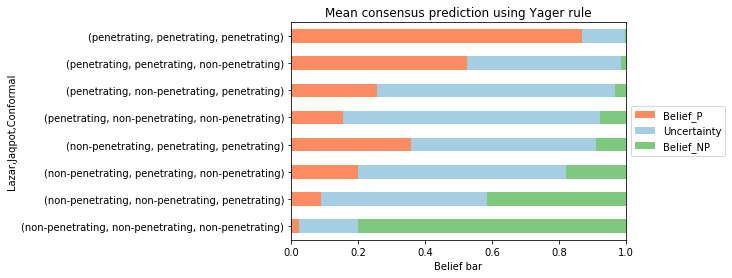

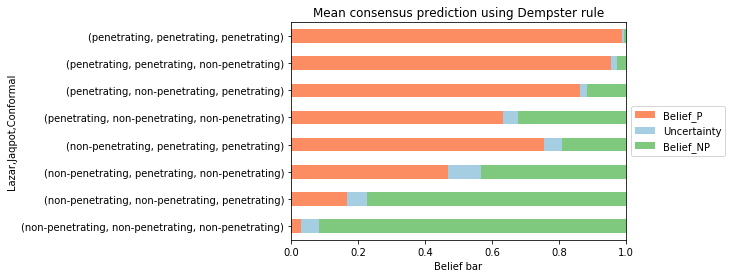

In [13]:
source = consensus_pred.groupby(['Lazar', 'Jaqpot', 'Conformal']).mean()[['Bel_Y', 'Uncertainty_Y']]
source['Belief_NP'] = 1. - source['Bel_Y'] - source['Uncertainty_Y']
source = source.rename(columns={'Bel_Y': 'Belief_P', 'Uncertainty_Y': 'Uncertainty'})
source

my_palette = ['#fc8d62', '#a6cee3', '#7fc97f']
ax = source.plot.barh(stacked=True, color=my_palette, xlim=(0., 1.), title="Mean consensus prediction using Yager rule").set_xlabel("Belief bar");

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig = ax.get_figure()
fig.savefig('a.png', bbox_inches='tight')

source = consensus_pred.groupby(['Lazar', 'Jaqpot', 'Conformal']).mean()[['Bel_D', 'Uncertainty_D']]
source['Belief_NP'] = 1. - source['Bel_D'] - source['Uncertainty_D']
source = source.rename(columns={'Bel_D': 'Belief_P', 'Uncertainty_D': 'Uncertainty'})
source

my_palette = ['#fc8d62', '#a6cee3', '#7fc97f']
ax = source.plot.barh(stacked=True, color=my_palette, xlim=(0., 1.), title="Mean consensus prediction using Dempster rule").set_xlabel("Belief bar");

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig = ax.get_figure()
fig.savefig('a.png', bbox_inches='tight')

**Collect compound names (mapping from SMILES to IUPAC name). These are used later to make visualizations easier to read.**

In [14]:
consensus_pred = consensus_pred.reset_index()
consensus_pred.head()

,SMILES,Bel_D,Bel_Y,Pls_D,Pls_Y,Pred_D,Pred_Y,Uncertainty_D,Uncertainty_Y,True,Lazar,Jaqpot,Conformal
0,OC[C@](c1onc(n1)c1ncn2-c3cccc(c3C(=O)N(Cc12)C)...,0.956241,0.509482,0.973003,0.985616,penetrating,penetrating,0.016762,0.476133,non-penetrating,penetrating,penetrating,non-penetrating
1,NCCc1nc2n(c1)cccc2,0.974438,0.631054,0.983247,0.989151,penetrating,penetrating,0.008809,0.358097,non-penetrating,penetrating,penetrating,penetrating
2,CCCN(CCC)CCc1ccc(c2c1CC(=C)N2)O,0.992618,0.948991,0.998585,0.998647,penetrating,penetrating,0.005967,0.049656,penetrating,penetrating,penetrating,penetrating
3,Fc1ccc2c(c1)onc2C1CCN(CC1)CCc1c(C)nc2n(c1=O)CC...,0.985652,0.796899,0.992708,0.994104,penetrating,penetrating,0.007056,0.197205,penetrating,penetrating,penetrating,penetrating
4,Clc1ccc2-n3c(CN=C(c2c1)c1ccccc1)nnc3C,0.993051,0.960317,0.998951,0.998985,penetrating,penetrating,0.005899,0.038668,penetrating,penetrating,penetrating,penetrating


**Collect compound info from Pubchem or read from json files**

In [15]:
if namesFromPubchem:
    smilesToName = {}

    for smiles in consensus_pred['SMILES'].tolist():
        url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/" + smiles + "/property/IUPACName/TXT"

        r = requests.get(url)

        if r.status_code == 200:
            name = r.text.strip('\n')
        else:
            name = smiles

        smilesToName[smiles] = name

    toJson = json.dumps(smilesToName)
    f = open("smilesToName.json","w")
    f.write(toJson)
    f.close()
    
    smilesToSyn = {}

    for smiles in consensus_pred['SMILES'].tolist():
        url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/" + smiles + "/synonyms/TXT"

        r = requests.get(url)

        if r.status_code == 200:
            name = r.text.split('\n')[0].upper()
        else:
            name = smiles

        smilesToSyn[smiles] = name

    import json

    toJson = json.dumps(smilesToSyn)
    f = open("smilesToSyn.json","w")
    f.write(toJson)
    f.close()     
else:
    with open("smilesToName.json", 'r') as f:
         smilesToName = json.load(f)
            
    with open("smilesToSyn.json", 'r') as f:
         smilesToSyn = json.load(f)

# add names to the consensus_pred
consensus_pred['Name'] = consensus_pred['SMILES'].map(smilesToName)
consensus_pred['Synonym'] = consensus_pred['SMILES'].map(smilesToSyn)

**Sort the compounds according to the experimental (`True` column) and input values (`Lazar` and `Jaqpot` columns). In this way, the true/false positives/negatives are grouped together and easier to distinguish.**

In [16]:
consensus_pred = consensus_pred.sort_values(by=['True', 'Lazar', 'Jaqpot', 'Conformal'])

**Create column with names to be used in the plots**

In [17]:
consensus_pred['Name_True'] = consensus_pred['Synonym'].str[0:15] + '_' + consensus_pred['True']
consensus_pred['Name_Jaqpot_Lazar_Conformal'] = consensus_pred['Synonym'].str[0:15] + '_' + consensus_pred['Jaqpot'] + '_' + consensus_pred['Lazar'] + '_'  + consensus_pred['Conformal']

**Consensus prediction (Dempster rule) per compound's true value**

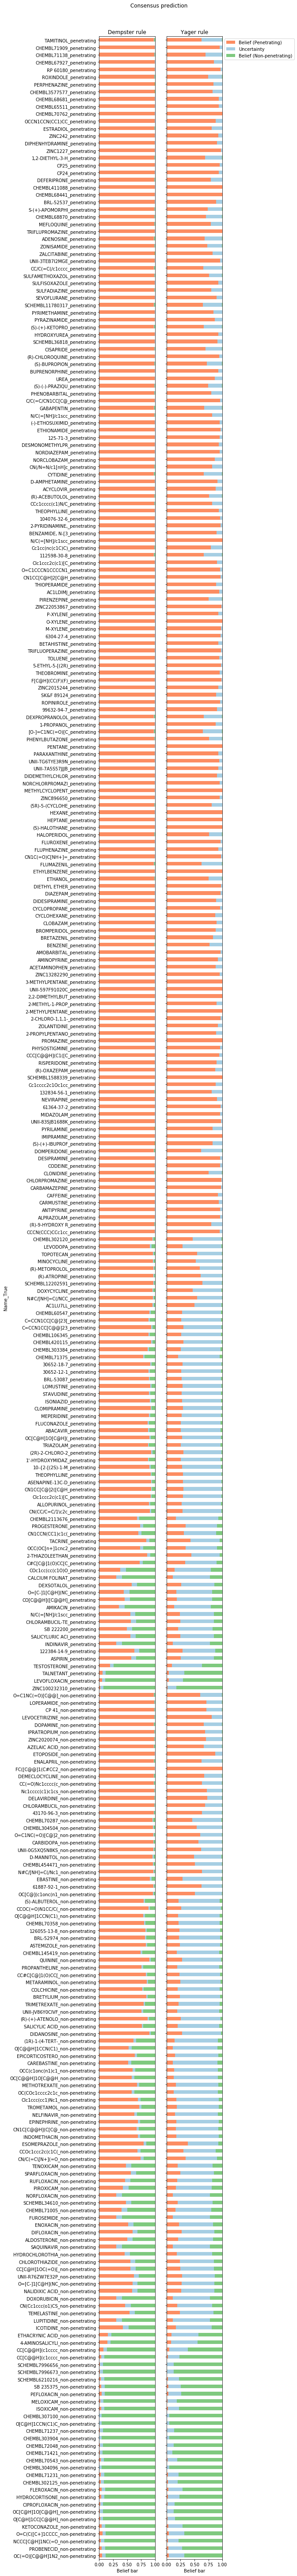

In [18]:
fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(30, 110))


# PLOT 1
# compute belief that compound is non-penetrating
consensus_pred['Belief (Non-penetrating)'] = 1. - consensus_pred['Bel_D'] - consensus_pred['Uncertainty_D']

df_plot = consensus_pred[['Bel_D', 'Uncertainty_D', 'Belief (Non-penetrating)', 'Jaqpot', 'Lazar', 'Name_True']].copy()

# rename columns (new names will be shown in the plot)
df_plot = df_plot.rename(columns={'Bel_D': 'Belief (Penetrating)', 'Uncertainty_D': 'Uncertainty'}).set_index(['Name_True'])
df_plot.plot.barh(figsize=(5, 105), stacked=True, color=my_palette, xlim=(0., 1.), title="Dempster rule", ax=ax1, legend=False).set_xlabel("Belief bar");


# PLOT 2
# compute belief that compound is non-penetrating
consensus_pred['Belief (Non-penetrating)'] = 1. - consensus_pred['Bel_Y'] - consensus_pred['Uncertainty_Y']

df_plot = consensus_pred[['Bel_Y', 'Uncertainty_Y', 'Belief (Non-penetrating)', 'Jaqpot', 'Lazar', 'Name_True']].copy()

# rename columns (new names will be shown in the plot)
df_plot = df_plot.rename(columns={'Bel_Y': 'Belief (Penetrating)', 'Uncertainty_Y': 'Uncertainty'}).set_index(['Name_True'])
df_plot.plot.barh(figsize=(5, 105), stacked=True, color=my_palette, xlim=(0., 1.), title="Yager rule", ax=ax2).set_xlabel("Belief bar");

fig.suptitle("Consensus prediction", y=0.89)

plt.legend(bbox_to_anchor=(1., 1.))
plt.show()

fig.savefig('prediction_vs_evidence.png', bbox_inches='tight')

**Consensus prediction (Dempster rule) per compound's combination of evidences**

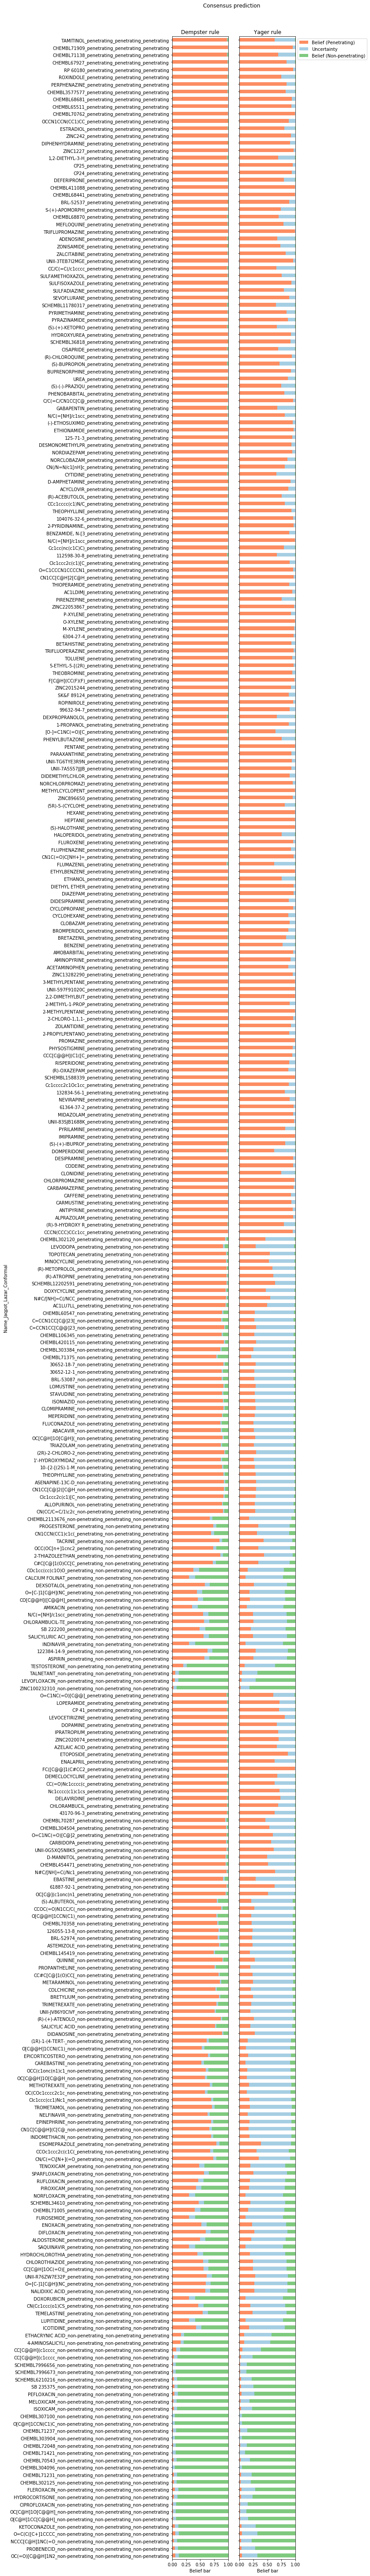

In [19]:
fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(30, 110))


# PLOT 1
# compute belief that compound is non-penetrating
consensus_pred['Belief (Non-penetrating)'] = 1. - consensus_pred['Bel_D'] - consensus_pred['Uncertainty_D']

df_plot = consensus_pred[['Bel_D', 'Uncertainty_D', 'Belief (Non-penetrating)', 'Name_Jaqpot_Lazar_Conformal']].copy()

# rename columns (new names will be shown in the plot)
df_plot = df_plot.rename(columns={'Bel_D': 'Belief (Penetrating)', 'Uncertainty_D': 'Uncertainty'}).set_index('Name_Jaqpot_Lazar_Conformal')
df_plot.plot.barh(figsize=(5, 105), stacked=True, color=my_palette, xlim=(0., 1.), title="Dempster rule", ax=ax1, legend=False).set_xlabel("Belief bar");


# PLOT 2
# compute belief that compound is non-penetrating
consensus_pred['Belief (Non-penetrating)'] = 1. - consensus_pred['Bel_Y'] - consensus_pred['Uncertainty_Y']

df_plot = consensus_pred[['Bel_Y', 'Uncertainty_Y', 'Belief (Non-penetrating)', 'Name_Jaqpot_Lazar_Conformal']].copy()

# rename columns (new names will be shown in the plot)
df_plot = df_plot.rename(columns={'Bel_Y': 'Belief (Penetrating)', 'Uncertainty_Y': 'Uncertainty'}).set_index('Name_Jaqpot_Lazar_Conformal')
df_plot.plot.barh(figsize=(5, 105), stacked=True, color=my_palette, xlim=(0., 1.), title="Yager rule", ax=ax2).set_xlabel("Belief bar");

fig.suptitle("Consensus prediction", y=0.89)

plt.legend(bbox_to_anchor=(1., 1.))
plt.show()

fig.savefig('prediction_vs_true.png', bbox_inches='tight')

**Print out dataframe and color cells depending on the content**

In [20]:
def highlightSensitisers(val):
    if (val == 'penetrating'):
        return 'background-color: #fc8d62;'
    elif (val =='non-penetrating'):
        return 'background-color: #7fc97f;'
    else:
        return 'background-color: #a6cee3;' 
    
df_plot = consensus_pred.copy()
df_plot = df_plot.set_index('SMILES')

df_plot = df_plot[['True', 'Lazar', 'Jaqpot', 'Conformal', 'Pred_Y', 'Pred_D', 'Uncertainty_Y', 'Uncertainty_D']].round(2)
df_plot = df_plot.style.applymap(highlightSensitisers, subset=['True', 'Pred_Y', 'Pred_D', 'Lazar', 'Jaqpot', 'Conformal'])

maxval = consensus_pred['Uncertainty_D'].max()*100
df_plot = df_plot.bar(subset=['Uncertainty_D'], align='left', color='#ffff99', width=maxval)

maxval = consensus_pred['Uncertainty_Y'].max()*100
df_plot = df_plot.bar(subset=['Uncertainty_Y'], align='left', color='#ffff99', width=maxval)

df_plot